In [1]:
# для устранения некоторых проблем с совместимостью
!pip install scikit-learn==0.23.2
!pip install scikit-optimize==0.8.1

In [2]:
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

Посмотрим на наши данные:

In [3]:
data = pd.read_csv('./auto_complectations.csv')
print(f'Missing values: {data.isnull().sum().sum()}')
data

Missing values: 0


,brand,model,complect,type_car,seats,doors,Двигатель,Мощность,Крутящий момент двигателя,Коробка передач,...,Разгон до сотни,Максимальная скорость,Расход топлива (л/100 км)\nгород / трасса / смешанный,Дорожный просвет,Габариты (длина × ширина × высота),Колёсная база,Объём багажника,Объём багажника максимальный,Объём топливного бака,Масса автомобиля
0,Audi,A3 Sedan,1.4 TFSI 7AMT,Седан класса C,5,4,бензиновый (1395 см³),150 л. с.,250 Н·м,роботизированная (7 ступеней),...,8.2 секунды,224 км/ч,5.9 / 4.1 / 4.8,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1320 кг
1,Audi,A3 Sedan,sport 1.4 TFSI 7AMT,Седан класса C,5,4,бензиновый (1395 см³),150 л. с.,250 Н·м,роботизированная (7 ступеней),...,8.2 секунды,224 км/ч,5.9 / 4.1 / 4.8,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1320 кг
2,Audi,A3 Sedan,2.0 TFSI 7AMT,Седан класса C,5,4,бензиновый (1984 см³),190 л. с.,320 Н·м,роботизированная (7 ступеней),...,6.8 секунды,250 км/ч,7.2 / 4.7 / 5.6,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1395 кг
3,Audi,A3 Sedan,2.0 TFSI 7AMT quattro,Седан класса C,5,4,бензиновый (1984 см³),190 л. с.,320 Н·м,роботизированная (7 ступеней),...,6.2 секунды,242 км/ч,7.2 / 4.8 / 5.7,165 мм,4458 × 1796 × 1416,2637 мм,390 л,845 л,55 л,1465 кг
4,Audi,A3 Sedan,sport 2.0 TFSI 7AMT,Седан класса C,5,4,бензиновый (1984 см³),190 л. с.,320 Н·м,роботизированная (7 ступеней),...,6.8 секунды,242 км/ч,7.2 / 4.7 / 5.6,165 мм,4458 × 1796 × 1416,2637 мм,425 л,880 л,50 л,1395 кг
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,Volvo,XC90,D5 AT 5S R-Design,Большой кроссовер,5,5,дизельный (1969 см³),235 л. с.,480 Н·м,автоматическая (8 ступеней),...,7.8 секунды,220 км/ч,6.4 / 5.5 / 5.8,237 мм,4950 × 2008 × 1776,2984 мм,721 л,1899 л,71 л,1969 кг
1699,Volvo,XC90,T6 AT 7S R-Design,Большой кроссовер,7,5,бензиновый (1969 см³),320 л. с.,400 Н·м,автоматическая (8 ступеней),...,6.5 секунды,230 км/ч,0 / 0 / 8.3,237 мм,4950 × 2008 × 1776,2984 мм,692 л,1899 л,71 л,2004 кг
1700,Volvo,XC90,D5 AT 7S R-Design,Большой кроссовер,7,5,дизельный (1969 см³),235 л. с.,480 Н·м,автоматическая (8 ступеней),...,7.8 секунды,220 км/ч,6.4 / 5.5 / 5.8,237 мм,4950 × 2008 × 1776,2984 мм,692 л,1899 л,71 л,2009 кг
1701,Volvo,XC90,T8 AT 7S Inscription,Большой кроссовер,7,5,гибридный (1969 см³),407 л. с.,640 Н·м,автоматическая (8 ступеней),...,5.6 секунды,230 км/ч,0 / 0 / 2.1,237 мм,4950 × 2008 × 1776,2984 мм,640 л,1899 л,70 л,2350 кг


Начнем с целевой переменной, type_car. В задаче указано, что "Классификация моделей (должна производится) по типу кузова (без подклассов, колонка type_car): - Седан - Хетчбек - Кроссовер - Внедорожник.", однако в колонке данные другого формата (т.е. там не четыре лейбла, а куча всего). При других обстоятельствах я бы уточнил у заказчика, как сопоставить имеющуюся разметку с необходимой, но думаю для целей учебного задания можно принять упрощенное предположение, что седан имеет слово "седан" в соответствующей колонке, хетчбэк - слово "хетчбэк" и т.д.

Was samples: 1703, remain after drop: 1472


/home/dmitrii/workspace/projects/ml/common_ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type_car', ylabel='count'>

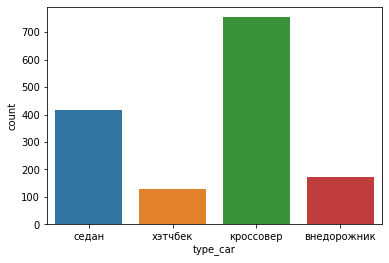

In [4]:
def shorten_car_type(car_type):
    if ('Седан' in car_type) or ('седан' in car_type):
        return 'седан'
    if ('Хэтчбек' in car_type) or ('хэтчбек' in car_type):
        return 'хэтчбек'
    if ('Кроссовер' in car_type) or ('кроссовер' in car_type):
        return 'кроссовер'
    if ('Внедорожник' in car_type) or ('внедорожник' in car_type):
        return 'внедорожник'
    else:
        return None

was_samples = data.shape[0]
data['type_car'] = data['type_car'].map(shorten_car_type)
data.dropna(subset=['type_car'], inplace=True)
print(f'Was samples: {was_samples}, remain after drop: {data.shape[0]}')

sns.countplot(data['type_car'])

В классах целевой переменной наблюдается небольшой имбаланс, не требующий скорее всего применения [специальных мер](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis); тем не менее, учтем его выбрав целевой метрикой f1_weighted.

Большая часть информации в датасете представлена текстом, и нам нужно извлечь из него полезные числовые значения:

In [5]:
data_prep = data.copy()
data_prep['engine_type'] = data['Двигатель'].str.split(' ').str[0]
data_prep['engine_volume'] = pd.to_numeric(data['Двигатель'].str.extract(r'(\d+)')[0])
data_prep['power'] = pd.to_numeric(data['Мощность'].str.extract(r'(\d+)')[0])
data_prep['torque'] = pd.to_numeric(data['Крутящий момент двигателя'].str.extract(r'(\d+)')[0])
data_prep['trans_type'] = data['Коробка передач'].str.split(' ').str[0]
data_prep['trans_st'] = pd.to_numeric(data['Коробка передач'].str.extract(r'(\d+)')[0])
data_prep['boost'] = pd.to_numeric(data['Разгон до сотни'].str.extract(r'([\d.]+)')[0])
data_prep['max_speed'] =  pd.to_numeric(data['Максимальная скорость'].str.extract(r'(\d+)')[0])

data_prep['cleer'] =  pd.to_numeric(data['Дорожный просвет'].str.extract(r'(\d+)')[0])
data_prep['wb'] =  pd.to_numeric(data['Колёсная база'].str.extract(r'(\d+)')[0])
data_prep['trunk_vol'] =  pd.to_numeric(data['Объём багажника'].str.extract(r'(\d+)')[0])
data_prep['trunk_vol_max'] =  pd.to_numeric(data['Объём багажника максимальный'].str.extract(r'(\d+)')[0])
data_prep['can_vol'] =  pd.to_numeric(data['Объём топливного бака'].str.extract(r'(\d+)')[0])
data_prep['weight'] =  pd.to_numeric(data['Масса автомобиля'].str.extract(r'(\d+)')[0])

cons_data = data['Расход топлива (л/100 км)\nгород / трасса / смешанный'].str.extract(r'(.+)\/(.+)\/(.+)').apply(pd.to_numeric)
cons_data.columns = ['cons_sity', 'cons_hw', 'cons_mixed']
data_prep = data_prep.merge(cons_data, how='left', left_index=True, right_index=True)

meas_data = data['Габариты (длина × ширина × высота)'].str.extract(r'(.+)×(.+)×(.+)').apply(pd.to_numeric)
meas_data.columns = ['length', 'width', 'height']
data_prep = data_prep.merge(meas_data, how='left', left_index=True, right_index=True)

data_prep.drop(columns=['Двигатель', 'Мощность','Крутящий момент двигателя',  'Коробка передач', 
                        'Разгон до сотни', 'Максимальная скорость', 'Дорожный просвет',
                        'Колёсная база', 'Объём багажника', 'Объём багажника максимальный', 
                        'Объём топливного бака', 'Масса автомобиля',
                        'Расход топлива (л/100 км)\nгород / трасса / смешанный', 
                        'Габариты (длина × ширина × высота)'], inplace=True)


Колонки 'model' и 'complect' -категориальные и содержат большое количество разных категорий, которые вызовут взрывной рост количества фичей при энкодинге и вероятно не будут полезны для классификации. Дропнем их:

In [6]:
print(data_prep['model'].nunique())
print(data_prep['complect'].nunique())
data_prep.drop(columns=['model', 'complect'], inplace=True)

202
1254


Можно заметить, что у нас появились нуллы:

In [7]:
data_prep.isnull().sum()

brand             0
type_car          0
seats             0
doors             0
Привод            0
engine_type       0
engine_volume     0
power             0
torque            0
trans_type        0
trans_st          0
boost            31
max_speed         0
cleer             0
wb                0
trunk_vol         0
trunk_vol_max     0
can_vol           0
weight            0
cons_sity         0
cons_hw           0
cons_mixed        0
length            0
width             0
height            0
dtype: int64

Действительно, в колонке "Разгон до сотни" они фактически есть. Разберемся с ними чуть позже в пайплайне.

In [8]:
data[data['Разгон до сотни']=='нет данных'].shape[0]

31

Перед обучением обозначим простой бейзлайн - модель, всегда выдающую наиболее вероятный класс:

In [9]:
f1_score(data_prep['type_car'], ['кроссовер']*data_prep.shape[0], average='weighted')

0.3470081839134341

А так же оставим небольшой валидационный датасет:

In [10]:
from sklearn.model_selection import train_test_split

X = data_prep.drop(columns=['type_car'])
y = data_prep['type_car']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=100, random_state=0)


Попробуем для начала относительно простой алгоритм логистической регрессии. Гиперпараметр регуляризации будем искать с помощью байесовской оптимизации (так удобнее всего):

In [11]:
categorical_features = ['brand', 'engine_type', 'trans_type', 'Привод']
numeric_features_to_impute = ['boost']
numeric_features = list(set(X.columns)-set(categorical_features)-set(numeric_features_to_impute))

preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    (
        'null_handler', 
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('imputed_scaler', StandardScaler())
        ]), 
        numeric_features_to_impute
    ),
    ('numeric_scaler', StandardScaler(), numeric_features)
])
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', multi_class='multinomial', solver='newton-cg'))
])

bs = BayesSearchCV(
    model,
    search_spaces={
        'classifier__C': Real(1e-5, 1e1, prior='log-uniform')
    },
    n_iter=20,
    scoring='f1_weighted',
    cv=5,
    random_state=0,
    n_jobs=-1
)
bs.fit(X_train, y_train)

print(f'Model best cv score: {bs.best_score_}')

/home/dmitrii/workspace/projects/ml/common_ml/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model best cv score: 0.9934672790497557


Как видно, достигнута очень высокая точность, дальнейшие улучшения не требуются. Проверим выбранную модель на валидационном датасете (при кросс-валидации оверфит маловероятен, но все же):

In [12]:
selected_model = bs.best_estimator_
f1_score(selected_model.predict(X_valid), y_valid, average='weighted')

1.0

Результат подтверждается, модель выбрана успешно.